# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import Subset


# transform_train = transforms.ToTensor()
transform_train = transforms.ToTensor()

# transform_test = transforms.ToTensor()
transform_test = transforms.ToTensor()

train_set = CIFAR10(
    root='./data/TransferLearning', train=True, download=True,
    transform=transform_train
)
test_set = CIFAR10(
    root='./data/TransferLearning', train=False, download=True,
    transform=transform_test
)

subset_idx = range(100)
train_subset = Subset(train_set, subset_idx)

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)

print(len(train_subset))
print(len(train_loader))

Files already downloaded and verified
Files already downloaded and verified
100
10


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

**Answer**  
The evaluation of the training procedure is hard due to the very small number of sample. The model could overfit the sample of the training data.  
Some solutions could be data augmentation or transfer learning.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ResNet18 from:  https://github.com/kuangliu/pytorch-cifar

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [7]:
# We define a pipeline calling preprocess, train_epoch and test 

from tqdm import tqdm

def preprocess(transform_train, transform_test):

    train_set = CIFAR10(
        root='./data/TransferLearning', train=True, download=True,
        transform=transform_train
    )
    test_set = CIFAR10(
        root='./data/TransferLearning', train=False, download=True,
        transform=transform_test
    )

    subset_idx = range(100)
    train_subset = Subset(train_set, subset_idx)

    return train_subset, test_set


def train_epoch(model, optimizer, criterion, data_loader, device):

    model.train()

    cum_loss = 0

    data_iterator = tqdm(data_loader, desc=f"Training")
    for i, batch in enumerate(data_iterator):
        x, y = batch
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        avg_loss = cum_loss/(i+1)

        data_iterator.set_postfix(loss=avg_loss)
    
    return cum_loss / len(data_iterator)


def test(model, data_loader, device):

    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Test"):
            x, y = batch
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            for idx, i in enumerate(outputs):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    accuracy = round(correct / total *100 , 3)
    
    print(f"Accuracy: {accuracy}")

    return accuracy

def pipeline(
    transform_train, transform_test,
    model, optimizer, criterion,
    num_epoch, batch_size, lr,
    scheduler=None,
    device=torch.device('cpu')
):
    train_set, test_set = preprocess(transform_train, transform_test)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    # print(f"partial optim is instanciated? {isinstance(optimizer, SGD)}")
    optimizer = optimizer(model.parameters(), lr=lr)
    # print(f"optim is instanciated? {isinstance(optimizer, SGD)}")
    criterion = criterion()
    # print(f"partial scheduler is instanciated? {isinstance(scheduler, lr_scheduler.CosineAnnealingLR)}")
    if scheduler is not None:
        scheduler = scheduler(optimizer)
    # print(f"scheduler is instanciated? {isinstance(scheduler, lr_scheduler.CosineAnnealingLR)}")

    for epoch in range(1, num_epoch):
        train_epoch(model, optimizer, criterion, train_loader, device)
        if scheduler is not None: 
            scheduler.step()
    
    train_accuracy = test(model, train_loader, device)
    test_accuracy = test(model, test_loader, device)

    return train_accuracy, test_accuracy


In [48]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam

import torchvision.transforms as transforms

from torch.optim import lr_scheduler
from functools import partial

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epoch = 10
batch_size = 10
lr = 0.01

train_acc_resnet_18, test_acc_resnet_18 = pipeline(
    transform_train, transform_test,
    ResNet18(), partial(SGD, momentum=0.9, weight_decay=5e-4), CrossEntropyLoss,
    num_epoch=10, batch_size=10, lr=0.01,
    scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=200),
    device=DEVICE
)

Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 10/10 [00:00<00:00, 85.90it/s]


Accuracy: 69.0


Test: 100%|██████████| 1000/1000 [00:07<00:00, 129.28it/s]

Accuracy: 20.72


| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on whole dataset |
|------|------|------|------| ------|
|   ResNet18  | 10 | 69.0% | 20.72% | 93.02% |

Accuracy on whole dataset as per https://github.com/kuangliu/pytorch-cifar/

In [14]:
train_accuracies = []
test_accuracies = []

for batch_size in [2, 4, 8, 16, 32]:
    train_accuracy, test_accuracy = pipeline(
        transform_train, transform_test,
        ResNet18, SGD, CrossEntropyLoss,
        num_epoch, batch_size, lr, 
        DEVICE
    )
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 5000/5000 [00:26<00:00, 190.74it/s]


Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 2500/2500 [00:13<00:00, 185.17it/s]


Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 1250/1250 [00:13<00:00, 95.05it/s] 


Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 625/625 [00:08<00:00, 74.93it/s]


Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 313/313 [00:07<00:00, 42.47it/s]


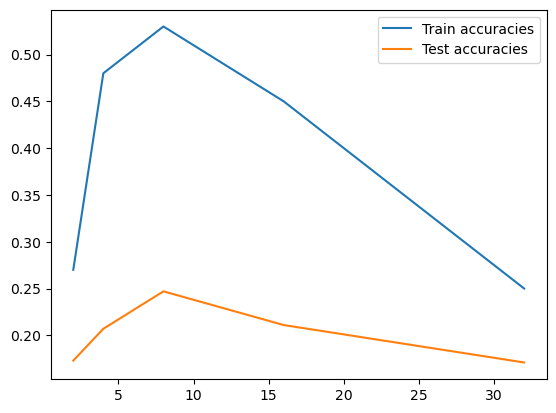

In [17]:
import matplotlib.pyplot as plt

plt.plot([2, 4, 8, 16, 32], train_accuracies, label="Train accuracies")
plt.plot([2, 4, 8, 16, 32], test_accuracies, label="Test accuracies")
plt.legend()
plt.show()

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [18]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
preprocessing = weights.transforms()
pretrained_model = resnet18(weights=weights)
pretrained_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alexa/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 44.7M/44.7M [00:02<00:00, 16.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
from torch.nn import Linear

# change the output size to correspond to CIFAR 10
pretrained_model.fc = Linear(in_features=512, out_features=1000, bias=True)

# freeze weights except last layer
for param in pretrained_model.parameters():
    param.requires_grad = False
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

In [20]:
from torch.optim import lr_scheduler
from functools import partial

train_acc_resnet_18_pretrained, test_acc_resnet_18_pretrained = pipeline(
    preprocessing, preprocessing,
    pretrained_model, partial(SGD, momentum=0.9, weight_decay=5e-4), CrossEntropyLoss,
    num_epoch=10, batch_size=10, lr=0.01,
    scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=200),
    device=DEVICE
)

Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 10/10 [00:00<00:00, 27.35it/s]


Accuracy: 100.0


Test: 100%|██████████| 1000/1000 [00:32<00:00, 30.94it/s]

Accuracy: 46.91


| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on whole dataset |
|------|------|------|------| ------|
|   ResNet18  | 10 | 100.0% | 50.49% | 93.02% |

Accuracy on whole dataset as per https://github.com/kuangliu/pytorch-cifar/

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

**Answer**

Performing these kind of transformation on small images can result in loss of information. For example when the image is translated, cropped or rotated, some pixels will turn black. There is too few pixels in the original image to allow this kind of loss of information. Scaling small image will deteriorate the quality and result in some loss of precious information, it can be interesting if the quality is good enough but not for small images. Color changes can deteriorate the color distribution or the texture or the original image.

To mitigate this problems we can use padding. Padding the input image before transforming it will mitigate the problems of black pixels (boundary effect). Interpolation can be used during scaling to produce smoother results in order to preserve details in the transformed image. Normalization of the input image can help standardize the color distribution.


## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [50]:
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomApply([
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomVerticalFlip(p=0.5),
#     ], p=0.2),
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#         transforms.RandomGrayscale(p=0.3),
#         transforms.RandomInvert(p=0.3)
#     ], p=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.RandomInvert(p=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epoch = 10
batch_size = 10
lr = 0.01

train_acc_resnet18_with_aug, test_acc_resnet_18_with_aug = pipeline(
    transform_train, transform_test,
    ResNet18(), partial(SGD, momentum=0.9, weight_decay=5e-4), CrossEntropyLoss,
    num_epoch=10, batch_size=10, lr=0.01,
    scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=200),
    device=DEVICE
)

Files already downloaded and verified
Files already downloaded and verified


Test: 100%|██████████| 10/10 [00:00<00:00, 62.27it/s]


Accuracy: 41.0


Test: 100%|██████████| 1000/1000 [00:08<00:00, 111.62it/s]

Accuracy: 20.9


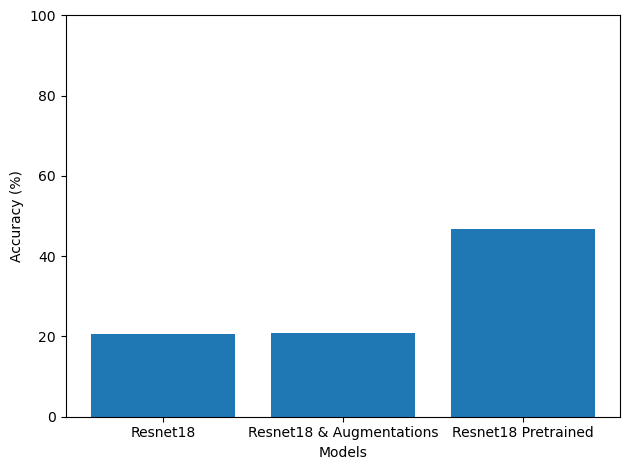

In [52]:
accs = [test_acc_resnet_18, test_acc_resnet_18_with_aug, test_acc_resnet_18_pretrained]
models = ["Resnet18", "Resnet18 & Augmentations","Resnet18 Pretrained"]
plt.bar(models, accs)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

1. The baseline
In the baseline, we achieve poor performance because the training set is too small.
The model has difficulties to extract features that are discriminative and generalizable, we can see that the model overfits the training data.

2. Data Augmentations
In the data augmentation method, we apply transformations to the training set. These transformations aim to prevent the model from focusing on features that are specific to the training image in terms of structure or colors. It allows the model to see more different inputs and to try and focus on more discriminative features. Introducing geometric perturbations allows to mititgatet the geometric priors. The increase in result is not really substantial in our example but we still have improvement.

3. Transfer Learning
In the Transfer Learning metod, we use a pretrained model that has already encountered a multitude of images. It can therefore be adapted to the CIFAR1 dataset rather easily by finetuning the last layers of the model. The advantage of this method is that we can leverage a big model, having encountered many images, and not being focuses on special structural features form input data, without a lot of training. Such a model will usually not be too focused on domain or structure of the images. HOwever it has to be chosen carefully depending on the datazst it has been trained on.
